# Install libraries

In [1]:
git remote add origin https://github.com/SjoerdLaurensse/ThesisDss-SjoerdLaurensse.git
git branch -M main
git push -u origin main

SyntaxError: ignored

In [ ]:
!pip install umap-learn
!pip install hdbscan
!pip install bertopic
!pip install huggingface_hub
!pip install keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=f3e9fd641f4700a3abe4e446cd0d445d8ca34505f8424c119be48baa0b1d6f3a
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=0f681b153a4cefc4a66bbe6ccd6f8ec568ab45e54653c0a01107976c1fc864b1
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/p

# Import packages

In [ ]:
import os
import math
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

# Statsmodels specific imports
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, aic

# Sklearn specific imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Keras and Tensorflow specific imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError


# NLP specific imports
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

# Other specific imports
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer


import warnings
from math import sqrt



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Predefine the train - val - test split

In [ ]:
# Define the minimum and maximum dates
min_date = pd.to_datetime('2009-01-01')
val_split = pd.to_datetime('2015-01-01')
test_split = pd.to_datetime('2017-01-01')
max_date = pd.to_datetime('2020-01-01')

# https://forecastegy.com/posts/time-series-cross-validation-python/

# Applying BERTopic 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Thesis Data Science Python/full_news_dataset.csv')

# Convert data types to right format
df['headline'] = df['headline'].astype(str)
df['headline_category'] = df['headline_category'].astype(str)
df['source'] = df['source'].astype(str)

# Convert the 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])


min_date_topics = pd.to_datetime('2017-01-01')
max_date_topics = pd.to_datetime('2020-01-01')

# Filter the dataset based on the date range
X_test_text = df[(df['date'] >= test_split) & (df['date'] < max_date)]

# Removing noise from text
def remove_noise(text):
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    html_pattern = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    special_pattern = re.compile(r'[^\w\s]|_')  # removes special characters except whitespace
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")
    
    # remove URLs
    text = re.sub(url_pattern, "", text)
    # remove HTML tags
    text = re.sub(html_pattern, "", text)
    # remove non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('utf-8')
    # remove special characters except whitespace
    text = re.sub(special_pattern, "", text)
    # remove emojis
    text = emoji_pattern.sub("", text)
    
    return text.strip()


# To get rid of all punctions, I will construct a function to remove it

def remove_punctuation(text):

    return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)

# Lemmatize words 
lemmatizer = WordNetLemmatizer()


# First, text is cleaned
# For each headline, I will turn every letter to lower case
X_test_text["headline_clean"] = X_test_text["headline"].apply(lambda x: x.lower())

# Then we will use the contractions package to expand contractions for the English language 
#df["headline_clean"] = df["headline_clean"].apply(lambda x: contractions.fix(x))

# Removing the noise with pre-defined function
X_test_text['headline_clean'] = X_test_text['headline_clean'].apply(lambda x: remove_noise(x))


# Removing punctuation with pre-defined function
X_test_text["headline_clean"] = X_test_text["headline_clean"].apply(lambda x: remove_punctuation(x))

# Tokenize words
X_test_text['headline_preprocessed'] = X_test_text['headline_clean'].apply(word_tokenize)

# Removing the stopwords from the corpus
stop = set(stopwords.words('english'))
X_test_text['headline_preprocessed'] = X_test_text['headline_preprocessed'].apply(lambda x: [word for word in x if word not in stop])

X_test_text['headline_lemma'] = X_test_text['headline_preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


keywords = ['crude oil', 'oil', 'crude', 'energy', 'russia', 'iran', 'solar', 'climate', 'gas', 'exxon', 'shell', 'bp', 'germany', 'climate', 'commodity',
            'nuclear', 'gasoline', 'saudi', 'tanker', 'petroleum', 'natural gas', 'europe', 'eu', 'usa']

# Create a function to check if any keyword is present in the headline
def contains_keywords(headline):
    for keyword in keywords:
        if keyword.lower() in headline.lower():
            return True
    return False

# Filter headlines using the contains_keywords function
X_test_text = X_test_text[X_test_text['headline_clean'].apply(contains_keywords)]

remaining_headlines_count = len(X_test_text)

print("Number of headlines after filtering:", remaining_headlines_count)

# Apply BERTopic that was previously made
topic_model = BERTopic.load("/content/drive/MyDrive/Thesis Data Science Python/topic_modelv6")


# Remove rows with missing values if any
X_test_text = X_test_text.dropna(subset=['headline_clean'])
# Ensure all elements in 'headline_clean' are strings
X_test_text['headline_clean'] = X_test_text['headline_clean'].astype(str)

print(X_test_text['headline_lemma'].isnull().sum())

# Remove rows with missing values if any
X_test_text = X_test_text.dropna(subset=['headline_lemma'])

# make 'headline_clean' strings
X_test_text['headline_lemma'] = X_test_text['headline_lemma'].astype(str)

# Set the date as index 
X_test_text.set_index('date', inplace=True)


Number of headlines after filtering: 15455
0


In [ ]:
# Load the dataset into docs
docs = X_test_text['headline_lemma'].tolist()

# Prepare embeddings for model - should be similar to the one used before
sentence_model = SentenceTransformer("all-MiniLM-L6-v2") 
embeddings = sentence_model.encode(docs, show_progress_bar=True)
topics, _ = topic_model.transform(docs, embeddings)

# Reduce outliers using the `distributions` strategy
new_topics = topic_model.reduce_outliers(docs, topics, strategy="distributions")

topic_model.update_topics(docs, topics=new_topics)

X_test_text['Updated_topics'] = new_topics

# Create a pivot table for further processing
pivot_table = X_test_text.pivot_table(index=X_test_text.index, columns='Updated_topics', aggfunc='size', fill_value=0)

# Normalize the counts by dividing each cell by the total count of documents for that day and fill na
normalized_table_updated = pivot_table.div(pivot_table.sum(axis=1), axis=0)
normalized_table_updated.fillna(0, inplace=True)
X_test_text = normalized_table_updated

X_test_text.to_csv('/content/drive/MyDrive/Thesis Data Science Python/topic_time_series_test_v6.csv')

Batches:   0%|          | 0/483 [00:00<?, ?it/s]

## Merge the train and test set for the topics together

In [ ]:
# Load datasets
topics_train = pd.read_csv('/content/drive/MyDrive/Thesis Data Science Python/topic_time_series_train_v6.csv')
topics_test = pd.read_csv('/content/drive/MyDrive/Thesis Data Science Python/topic_time_series_test_v6.csv')


In [ ]:
# Converting dates to datetime so that they can be merged
topics_train['date'] = pd.to_datetime(topics_train['date'])
topics_test['date'] = pd.to_datetime(topics_test['date'])

topics_train.index = pd.to_datetime(topics_train.index)
topics_test.index = pd.to_datetime(topics_test.index)

topics = pd.concat([topics_train, topics_test])
topics.set_index(['date'], inplace = True)

In [ ]:
# Load price data
price_df = pd.read_csv('/content/drive/MyDrive/Thesis Data Science Python/merged_price_data.csv')

# Convert datetime and index setting
price_df['date'] = pd.to_datetime(price_df['date'])
price_df.set_index('date', inplace=True)

merged_df = price_df.merge(topics, how='left', left_index=True, right_index=True)
# If no topics exist for a day, then fill with 0 
merged_df = merged_df.fillna(0)
# Drop columsn that were initially intended to be used
merged_df = merged_df.drop(['-1', 'dji_price', 'usd_price', 'gold_price'],axis=1)

# Define the start and end dates for filtering
start_date = '2009-01-01'
end_date = '2020-01-01'

# Apply filter to be sure that date range is right
full_df = merged_df.loc[start_date:end_date]

# Preprocessing

## Normalize oil price

In [ ]:
# Make function to normlize the column that is specified for the dataframe that is specified
def normalize_column(df, column_name):
    df_copy = df.copy() 
    scaler = MinMaxScaler()

    # data should be reshaped
    data = df_copy[column_name].values.reshape(-1, 1)
    
  
    normalized_data = scaler.fit_transform(data)

    # Add normalized data as a new column
    df_copy[column_name + '_norm'] = normalized_data
    return df_copy, scaler

# Create a new df
normalized_df, scaler = normalize_column(full_df, 'oil_price')

## Create supervised learning by lagging variables & assigning x and y

In [ ]:
# Lag all variables one lag with shift function
full_dataset = normalized_df.copy()
full_dataset = full_dataset.shift(1)

# Make sure target variable is not shifted
full_dataset['oil_price_target_norm'] = normalized_df['oil_price_norm']

# Drop the non-normalized value
full_dataset.drop(['oil_price'],axis=1, inplace = True)

# Drop first row because pd dataframe was shifted
full_dataset = full_dataset.iloc[1:]

# Define X and y
y = pd.DataFrame()
y = full_dataset['oil_price_target_norm']
y = y.to_frame()
X = pd.DataFrame()
X = full_dataset
X = X.drop(['oil_price_target_norm'], axis = 1)

# Define feature sets in terms of X
X_base = X['oil_price_norm']
X_base = X_base.to_frame()
X_all = X 


# Split the datasets into training and validation sets while preserving the order
X_train_base, X_test_base   = X_base[:test_split], X_base[test_split:]
X_train_all, X_test_all = X[:test_split], X[test_split:]
y_train, y_test  = y[:test_split], y[test_split:]


# Define feature sets 
feature_sets = {
    'oil_features' : (X_train_base),
    'all_features': (X_train_all), 
    'y_value' : (y_train)
}


# Split the datasets into training and validation sets while preserving the order
X_train_base, X_val_base   = X_train_base[:val_split], X_train_base[val_split:]
X_train_all, X_val_all = X_train_all[:val_split], X_train_all[val_split:]
y_train, y_val  = y_train[:val_split], y_train[val_split:]


## Define y and X

## Split the train set into a validation and train set

# Recursive feature elimination that returns new dataframe with optimal features

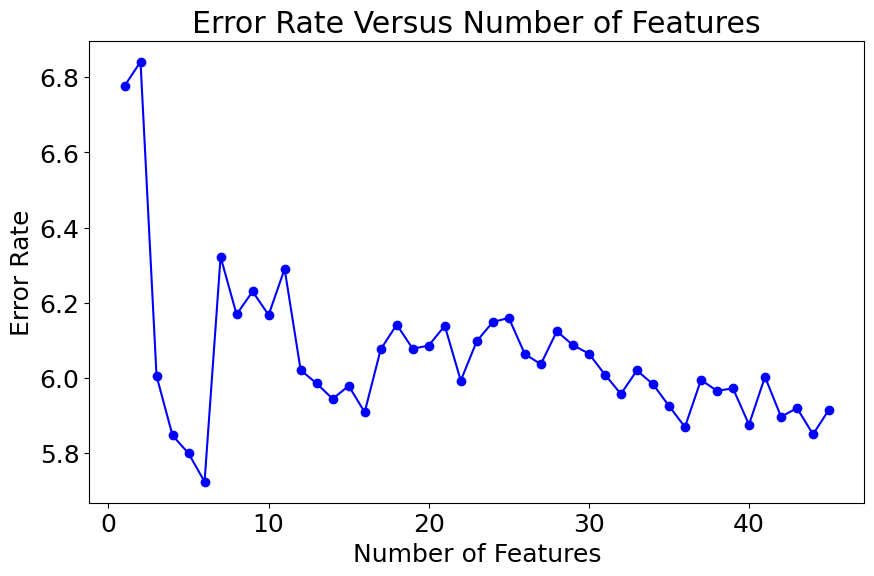

Optimal number of features: 6
Lowest error: 5.724243268492067


In [ ]:
# define rf 
rf = RandomForestRegressor(random_state=42)

# make list for error rates
error_rate = []

# make variables to check optimal numbers
min_error = float('inf')  
optimal_num_features = None
optimal_features = None

# Start with all features and remove one each time
for num_features in range(X_train_all.shape[1], 0, -1):

    # Define the RFE object and rank each feature
    rfe = RFE(estimator=rf, n_features_to_select=num_features, step=1)
    rfe = rfe.fit(X_train_all, y_train)

    # Names of most important features
    selected_features = [X_train_all.columns[i] for i in rfe.get_support(indices=True)]

    # Train model with selected features for this loop and make predictions
    rf.fit(X_train_all[selected_features], y_train)
    pred = rf.predict(X_val_all[selected_features])

    # Make sure to inverse transform normalized values
    pred_inverse = scaler.inverse_transform(pred.reshape(-1, 1))
    y_val_inverse = scaler.inverse_transform(y_val.values.reshape(-1, 1))
    
    # Compute error rate and append to list
    error = mean_squared_error(y_val_inverse, pred_inverse)
    error_rate.append(error)

    # Update the optimal number of features and error if the current error is smaller
    if error < min_error:
        min_error = error
        optimal_num_features = num_features
        optimal_features = selected_features

# Should plot the error rate for optimal number of features
plt.figure(figsize=(10, 6))
plt.plot(range(X_train_all.shape[1], 0, -1), error_rate, marker='o', linestyle='-', color='b')
plt.title("Error Rate Versus Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Error Rate")
plt.savefig('/content/drive/MyDrive/Thesis Data Science Python/RFE_results.jpg')
plt.show()

print(f"Optimal number of features: {optimal_num_features}")
print(f"Lowest error: {min_error}")




In [ ]:
# Update X_train_all and X_test_all based on the optimal number of features for further processing
X_train_all = X_train_all[optimal_features]
X_val_all = X_val_all[optimal_features]
X_test_all = X_test_all[optimal_features]

# Baseline models

## Baseline Support Vector Regressor & Random Forest Regressor

In [ ]:

# Define the function to calculate the SVR and RF baseline
def calculate_metrics(models, y_train, y_val):
    # make dictionary for results
    metrics = {'Model':[], 'MAE':[], 'RMSE':[]}
    for algorithm in [SVR(kernel='rbf'), RandomForestRegressor(random_state=42)]:
        algo_name = algorithm.__class__.__name__
        for model_name, (X_train, X_val) in models.items():
            algo.fit(X_train, y_train)
            y_pred = algorithm.predict(X_val)
            # Inverse transform the y_val and y_pred
            y_val_inverse = scaler.inverse_transform(y_val.values.reshape(-1, 1))
            y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))

            # calculate the errors
            mae = mean_absolute_error(y_val_inverse, y_pred_inverse)
            rmse = sqrt(mean_squared_error(y_val_inverse, y_pred_inverse))

            # print the results
            print(f"{algo_name} with {model_name} MAE: ", mae)
            print(f"{algo_name} with {model_name} RMSE: ", rmse)
            metrics['Model'].append(f"{algo_name} with {model_name}")
            metrics['MAE'].append(mae)
            metrics['RMSE'].append(rmse)
    # return the dictionary as a pandas dataframe
    return pd.DataFrame(metrics)

models = {
    'oil_features' : (X_train_base, X_val_base),
    'all_features': (X_train_all, X_val_all)
}

results_df = calculate_metrics(models, y_train, y_val)


SVR with oil_features MAE:  4.3301574666905625
SVR with oil_features RMSE:  5.913084608280585
SVR with all_features MAE:  3.842303765058255
SVR with all_features RMSE:  5.5206065282765335
RandomForestRegressor with oil_features MAE:  1.8507310874905538
RandomForestRegressor with oil_features RMSE:  2.603174264359808
RandomForestRegressor with all_features MAE:  1.6208168650793657
RandomForestRegressor with all_features RMSE:  2.330581219935975


## Baseline LSTM model

In [ ]:
# reshape input for LSTM to 3D [samples, timesteps, features]
X_train_base_LSTM = np.array(X_train_base).reshape((X_train_base.shape[0], 1, X_train_base.shape[1]))
X_val_base_LSTM = np.array(X_val_base).reshape((X_val_base.shape[0], 1, X_val_base.shape[1]))
X_train_all_LSTM = np.array(X_train_all).reshape((X_train_all.shape[0], 1, X_train_all.shape[1]))
X_val_all_LSTM = np.array(X_val_all).reshape((X_val_all.shape[0], 1, X_val_all.shape[1]))




In [ ]:
# define two LSTM models: one for base and one for all
model_base = Sequential()
model_base.add(LSTM(50, input_shape=(X_train_base_LSTM.shape[1], X_train_base_LSTM.shape[2])))
model_base.add(Dropout(0.2))
model_base.add(Dense(1))
model_base.compile(loss='mae', optimizer='adam')

model_all = Sequential()
model_all.add(LSTM(50, input_shape=(X_train_all_LSTM.shape[1], X_train_all_LSTM.shape[2])))
model_all.add(Dropout(0.2))
model_all.add(Dense(1))
model_all.compile(loss='mae', optimizer='adam')

# fit network
history_base = model_base.fit(X_train_base_LSTM, y_train, epochs=100, batch_size=72, validation_data=(X_val_base_LSTM, y_val), verbose=2, shuffle=False)
history_all = model_all.fit(X_train_all_LSTM, y_train, epochs=100, batch_size=72, validation_data=(X_val_all_LSTM, y_val), verbose=2, shuffle=False)

# prediction
y_pred_base = model_base.predict(X_val_base_LSTM)
y_pred_all = model_all.predict(X_val_all_LSTM)

# inverse transform the y_val and y_pred
y_val_inverse = scaler.inverse_transform(y_val.values.reshape(-1, 1))
y_pred_base_inverse = scaler.inverse_transform(y_pred_base)
y_pred_all_inverse = scaler.inverse_transform(y_pred_all)

# calculate RMSE for both models
rmse_base = np.sqrt(mean_squared_error(y_val_inverse, y_pred_base_inverse))
rmse_all = np.sqrt(mean_squared_error(y_val_inverse, y_pred_all_inverse))

# calculate MAE for both models
mae_base = mean_absolute_error(y_val_inverse, y_pred_base_inverse)
mae_all = mean_absolute_error(y_val_inverse, y_pred_all_inverse)

print('Base Model RMSE: %.3f' % rmse_base)
print('Base Model MAE: %.3f' % mae_base)
print('All Features Model RMSE: %.3f' % rmse_all)
print('All Features Model MAE: %.3f' % mae_all)

Epoch 1/100
21/21 - 3s - loss: 0.6548 - val_loss: 0.1461 - 3s/epoch - 125ms/step
Epoch 2/100
21/21 - 0s - loss: 0.5340 - val_loss: 0.0750 - 115ms/epoch - 5ms/step
Epoch 3/100
21/21 - 0s - loss: 0.3941 - val_loss: 0.0721 - 119ms/epoch - 6ms/step
Epoch 4/100
21/21 - 0s - loss: 0.2321 - val_loss: 0.1926 - 113ms/epoch - 5ms/step
Epoch 5/100
21/21 - 0s - loss: 0.0854 - val_loss: 0.3021 - 113ms/epoch - 5ms/step
Epoch 6/100
21/21 - 0s - loss: 0.0931 - val_loss: 0.2882 - 119ms/epoch - 6ms/step
Epoch 7/100
21/21 - 0s - loss: 0.0928 - val_loss: 0.2740 - 112ms/epoch - 5ms/step
Epoch 8/100
21/21 - 0s - loss: 0.0867 - val_loss: 0.2715 - 114ms/epoch - 5ms/step
Epoch 9/100
21/21 - 0s - loss: 0.0874 - val_loss: 0.2632 - 112ms/epoch - 5ms/step
Epoch 10/100
21/21 - 0s - loss: 0.0848 - val_loss: 0.2559 - 102ms/epoch - 5ms/step
Epoch 11/100
21/21 - 0s - loss: 0.0837 - val_loss: 0.2506 - 100ms/epoch - 5ms/step
Epoch 12/100
21/21 - 0s - loss: 0.0835 - val_loss: 0.2430 - 99ms/epoch - 5ms/step
Epoch 13/100
21

# Hyperparameter tuning

### RF Hyperparameter tuning 

In [ ]:
# Hyperparameters to tune
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [2, 6, 10, 14, 16, 20],
}

# Function to tune hyperparameters
def tune_hyperparameters(X_train, X_val, y_train, y_val, feature_set):
    # Initialize the random forest regressor
    rf = RandomForestRegressor()

    # RandomizedSearchCV (for now without timeseriesplit)
    #tscv = TimeSeriesSplit(n_splits=5)
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=100, verbose=2, random_state=42, 
                                   n_jobs=-1)

    # Fit the model on the training data
    rf_random.fit(X_train, y_train)

    # Predict on the validation data
    y_pred = rf_random.predict(X_val)

    y_val_inverse = scaler.inverse_transform(y_val.values.reshape(-1, 1))
    y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))

           
    mae = mean_absolute_error(y_val_inverse, y_pred_inverse)
    rmse = sqrt(mean_squared_error(y_val_inverse, y_pred_inverse))

    return {
        'Feature Set': feature_set,
        'Best Hyperparameters': rf_random.best_params_,
        'MAE': mae,
        'RMSE': rmse,
    }

results_rf_tuning = []
results_rf_tuning.append(tune_hyperparameters(X_train_all, X_val_all, y_train, y_val, 'All Features'))
results_rf_tuning.append(tune_hyperparameters(X_train_base, X_val_base, y_train, y_val, 'Base Features'))

results_rf_tuning = pd.DataFrame(results_rf_tuning)
results_rf_tuning



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


,Feature Set,Best Hyperparameters,MAE,RMSE
0,All Features,"{'n_estimators': 50, 'min_samples_split': 2, '...",1.621065,2.321431
1,Base Features,"{'n_estimators': 200, 'min_samples_split': 6, ...",1.545602,2.268641


## SVR


In [ ]:
# hyperparameters to tune
param_dist = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

def tune_hyperparameters(X_train, X_val, y_train, y_val, feature_set):
    # Initialize the SVR
    svr = SVR()

    # Initialize the RandomizedSearchCV (without TimeSeriesSplit for now)
    #tscv = TimeSeriesSplit(n_splits=5)
    svr_random = RandomizedSearchCV(estimator=svr, param_distributions=param_dist, 
                                    n_iter=100, verbose=2, random_state=42, 
                                    n_jobs=-1)

    # Fit the model on the training data
    svr_random.fit(X_train, y_train)

    # Predict on the validation data
    y_pred = svr_random.predict(X_val)
  
    y_val_inverse = scaler.inverse_transform(y_val.values.reshape(-1, 1))
    y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))

           
    mae = mean_absolute_error(y_val_inverse, y_pred_inverse)
    rmse = sqrt(mean_squared_error(y_val_inverse, y_pred_inverse))

    return {
        'Feature Set': feature_set,
        'Best Hyperparameters': svr_random.best_params_,
        'MAE': mae,
        'RMSE': rmse,
    }

# append results into the list and then turn into df
results_svr_tuning = []
results_svr_tuning.append(tune_hyperparameters(X_train_all, X_val_all, y_train, y_val, 'All Features'))
results_svr_tuning.append(tune_hyperparameters(X_train_base, X_val_base, y_train, y_val, 'Base Features'))

results_svr_tuning = pd.DataFrame(results_svr_tuning)
results_svr_tuning

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits


,Feature Set,Best Hyperparameters,MAE,RMSE
0,All Features,"{'kernel': 'linear', 'C': 10}",2.878869,3.234405
1,Base Features,"{'kernel': 'linear', 'C': 10}",2.450408,2.723782


## LSTM parameter tuning

In [ ]:
# Build model with function and define hyperparameters
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Choice('units', [4, 8, 16, 32, 64, 128, 256])))
    model.add(layers.Dropout(hp.Choice('dropout', [0.05, 0.15, 0.25])))
    model.add(layers.Dense(1, activation=hp.Choice('dense_activation', ['linear', 'softmax'])))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [0.01, 0.001, 0.0001])),
        loss='mae')
    return model


# Get the Keras tuner in place and define it
tuner_all = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # you can adjust this number
    directory='model_dir_all',
    project_name='oil_price_lstm_all')

# Deploy the tuner to the data
tuner_all.search(X_train_all_LSTM, y_train, epochs=100, validation_data=(X_val_all_LSTM, y_val))

# Get the optimal hyperparameters for all feature set
best_hps_all = tuner_all.get_best_hyperparameters(num_trials=1)[0]

tuner_base = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,  # you can adjust this number
    directory='model_dir_base',
    project_name='oil_price_lstm_base')

tuner_base.search(X_train_base_LSTM, y_train, epochs=100, validation_data=(X_val_base_LSTM, y_val))

# Get the optimal hyperparameters for base feature set
best_hps_base = tuner_base.get_best_hyperparameters(num_trials=1)[0]


# Define function to evaluate model
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    y_val_inverse = scaler.inverse_transform(y_val.values.reshape(-1, 1))
    y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))
    mae = mean_absolute_error(y_val_inverse, y_pred_inverse)
    rmse = sqrt(mean_squared_error(y_val_inverse, y_pred_inverse))
    return mae, rmse

# Get best models
best_model_base = tuner_base.get_best_models(num_models=1)[0]
best_model_all = tuner_all.get_best_models(num_models=1)[0]

# Evaluate models
mae_base, rmse_base = evaluate_model(best_model_base, X_val_base_LSTM, y_val)
mae_all, rmse_all = evaluate_model(best_model_all, X_val_all_LSTM, y_val)

# Retrieve best hyperparameters
best_hyperparameters_base = tuner_base.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters_all = tuner_all.get_best_hyperparameters(num_trials=1)[0]

# Create DataFrame
results_LSTM_tuning = pd.DataFrame({
    'Datasets': ['Base', 'All'],
    'MAE': [mae_base, mae_all],
    'RMSE': [rmse_base, rmse_all],
    'Hyperparameters': [best_hyperparameters_base.values, best_hyperparameters_all.values]
})

results_LSTM_tuning


Trial 100 Complete [00h 00m 27s]
val_loss: 0.019987689331173897

Best val_loss So Far: 0.01128688920289278
Total elapsed time: 00h 52m 20s
16/16 [==============================] - 1s 2ms/step


,Datasets,MAE,RMSE,Hyperparameters
0,Base,0.977332,1.226378,"{'units': 128, 'dropout': 0.15, 'dense_activat..."
1,All,0.984102,1.232699,"{'units': 256, 'dropout': 0.05, 'dense_activat..."


# Test data

In [ ]:
# Split the datasets into training and validation sets while preserving the order
X_train_base, X_test_base   = X_base[:test_split], X_base[test_split:]
X_train_all, X_test_all = X[:test_split], X[test_split:]
y_train, y_test  = y[:test_split], y[test_split:]


# Define feature sets 
feature_sets = {
    'oil_features' : (X_train_base),
    'all_features': (X_train_all), 
    'y_value' : (y_train)
}



In [ ]:
X_train_all = X_train_all[optimal_features]
X_test_all = X_test_all[optimal_features]

### Random Forest

In [ ]:
# define the validate_model function
def validate_model(X_train, y_train, X_test, y_test, best_params):
    model = RandomForestRegressor(**best_params)
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)

    # Inverse transform the y_val and y_pred
    y_test_inverse = scaler.inverse_transform(y_test.values.reshape(-1, 1))
    y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    rmse = sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
    return mae, rmse, y_pred_inverse, y_test_inverse

# Define best parameters for all features and base features
best_params_all = results_rf_tuning.loc[results_rf_tuning['Feature Set'] == 'All Features', 'Best Hyperparameters'].values[0]
best_params_base = results_rf_tuning.loc[results_rf_tuning['Feature Set'] == 'Base Features', 'Best Hyperparameters'].values[0]

    
# Call function to get results and values for plotting
mae_base, rmse_base, y_pred_base_rf, y_test_base_rf = validate_model(X_train_base, y_train, X_test_base, y_test, best_params_base)
mae_all, rmse_all, y_pred_all_rf, y_test_all_rf = validate_model(X_train_all, y_train, X_test_all, y_test, best_params_all)

# Print the results
print(f"Base Features - MAE: {mae_base}, RMSE: {rmse_base}")
print(f"All Features - MAE: {mae_all}, RMSE: {rmse_all}")


Base Features - MAE: 0.9753046442215969, RMSE: 1.2530684741319735
All Features - MAE: 1.055896654971581, RMSE: 1.3456855311012137


## SVR

In [ ]:
from sklearn.svm import SVR

# Define the validation function
def validate_model(X_train, y_train, X_test, y_test, best_params):
    # use **best_params from scikit-learn
    model = SVR(**best_params)
    # get the values and then use numpy ravel to flatten it
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    y_test_inverse = scaler.inverse_transform(y_test.values.reshape(-1, 1))
    y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    rmse = sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
    return mae, rmse, y_test_inverse, y_pred_inverse

# Define best parameters for all features and base features for SVR
best_params_all_svr = results_svr_tuning.loc[results_svr_tuning['Feature Set'] == 'All Features', 'Best Hyperparameters'].values[0]
best_params_base_svr = results_svr_tuning.loc[results_svr_tuning['Feature Set'] == 'Base Features', 'Best Hyperparameters'].values[0]

# Call the function to get results and values for plotting
mae_base_svr, rmse_base_svr, y_test_base_svr, y_pred_base_svr = validate_model(X_train_base, y_train, X_test_base, y_test, best_params_base_svr)
mae_all_svr, rmse_all_svr, y_test_all_svr, y_pred_all_svr = validate_model(X_train_all, y_train, X_test_all, y_test, best_params_all_svr)


print(f"SVR - Base Features - MAE: {mae_base_svr}, RMSE: {rmse_base_svr}")
print(f"SVR - All Features - MAE: {mae_all_svr}, RMSE: {rmse_all_svr}")


SVR - Base Features - MAE: 1.9342317549984136, RMSE: 2.178116208404538
SVR - All Features - MAE: 2.23895366877076, RMSE: 2.5329873837409953


## LSTM

In [ ]:
# reshape input for LSTM to 3D [samples, timesteps, features]
X_train_all_LSTM = np.array(X_train_all).reshape((X_train_all.shape[0], 1, X_train_all.shape[1]))
X_test_all_LSTM = np.array(X_test_all).reshape((X_test_all.shape[0], 1, X_test_all.shape[1]))

# also for base feature set
X_train_base_LSTM = np.array(X_train_base).reshape((X_train_base.shape[0], 1, X_train_base.shape[1]))
X_test_base_LSTM = np.array(X_test_base).reshape((X_test_base.shape[0], 1, X_test_base.shape[1]))

In [ ]:
# manually made the model based on optimal parameters
model_base = Sequential()
model_base.add(LSTM(128, activation='relu', input_shape=(X_train_base_LSTM.shape[1], X_train_base_LSTM.shape[2])))
model_base.add(Dropout(0.15))
model_base.add(Dense(1, activation='linear'))

model_base.compile(loss='mean_squared_error', 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                   metrics=['mae', 'mse'])


In [ ]:
# manualy made model on optimal parameters for full feature set
model_all = Sequential()
model_all.add(LSTM(256, activation='relu', input_shape=(X_train_all_LSTM.shape[1], X_train_all_LSTM.shape[2])))
model_all.add(Dropout(0.05))
model_all.add(Dense(1, activation='linear'))

model_all.compile(loss='mean_squared_error', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                  metrics=['mae', 'mse'])


# fit the network
history_base = model_base.fit(X_train_base_LSTM, y_train, epochs=10, batch_size=32, validation_split=0.2)

history_all = model_all.fit(X_train_all_LSTM, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
38/38 [==============================] - 2s 13ms/step - loss: 0.0869 - mae: 0.2186 - mse: 0.0869 - val_loss: 0.0129 - val_mae: 0.1058 - val_mse: 0.0129
Epoch 2/10
38/38 [==============================] - 0s 6ms/step - loss: 0.0101 - mae: 0.0769 - mse: 0.0101 - val_loss: 0.0029 - val_mae: 0.0411 - val_mse: 0.0029
Epoch 3/10
38/38 [==============================] - 0s 6ms/step - loss: 0.0062 - mae: 0.0606 - mse: 0.0062 - val_loss: 0.0015 - val_mae: 0.0297 - val_mse: 0.0015
Epoch 4/10
38/38 [==============================] - 0s 6ms/step - loss: 0.0037 - mae: 0.0473 - mse: 0.0037 - val_loss: 0.0012 - val_mae: 0.0321 - val_mse: 0.0012
Epoch 5/10
38/38 [==============================] - 0s 6ms/step - loss: 0.0028 - mae: 0.0421 - mse: 0.0028 - val_loss: 3.1591e-04 - val_mae: 0.0141 - val_mse: 3.1591e-04
Epoch 6/10
38/38 [==============================] - 0s 6ms/step - loss: 0.0027 - mae: 0.0408 - mse: 0.0027 - val_loss: 2.2278e-04 - val_mae: 0.0114 - val_mse: 2.2278e-04
Epoch 7/10


24/24 [==============================] - 0s 2ms/step


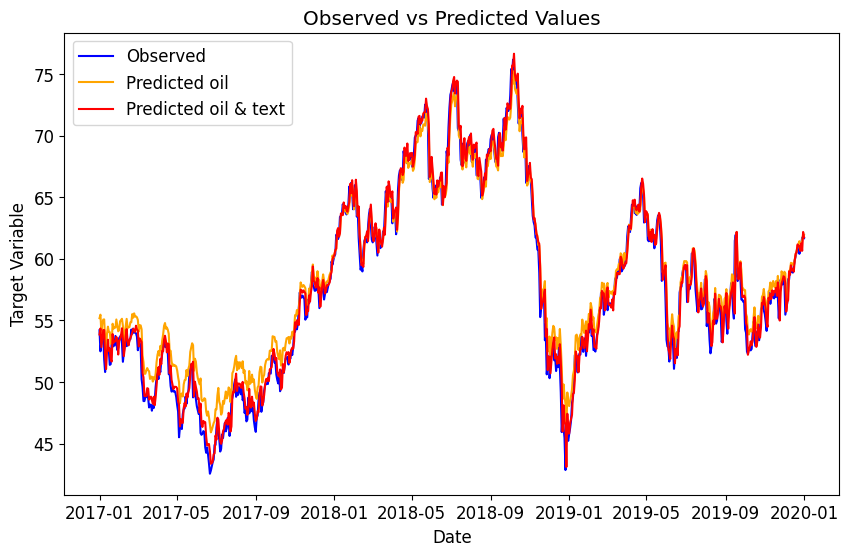

    set       mae      rmse
0  base  1.316748  1.655193
1   all  0.808149  1.107897


In [ ]:
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# Predict values for the base set
y_pred_base = model_base.predict(X_test_base_LSTM)

y_test_inverse = scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_inverse_base_lstm = scaler.inverse_transform(y_pred_base.reshape(-1, 1))
# Compute metrics for the base set
mae_base, rmse_base = compute_metrics(y_test_inverse, y_pred_inverse_base_lstm)

# Predict values for the all set
y_pred_all = model_all.predict(X_test_all_LSTM)

y_test_inverse = scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_inverse_all_lstm = scaler.inverse_transform(y_pred_all.reshape(-1, 1))
# Compute metrics for the all set
mae_all, rmse_all = compute_metrics(y_test_inverse, y_pred_inverse_all_lstm)



# Create df to store results
results_df = pd.DataFrame({
    'set': ['base', 'all'],
    'mae': [mae_base, mae_all],
    'rmse': [rmse_base, rmse_all]
})

print(results_df)

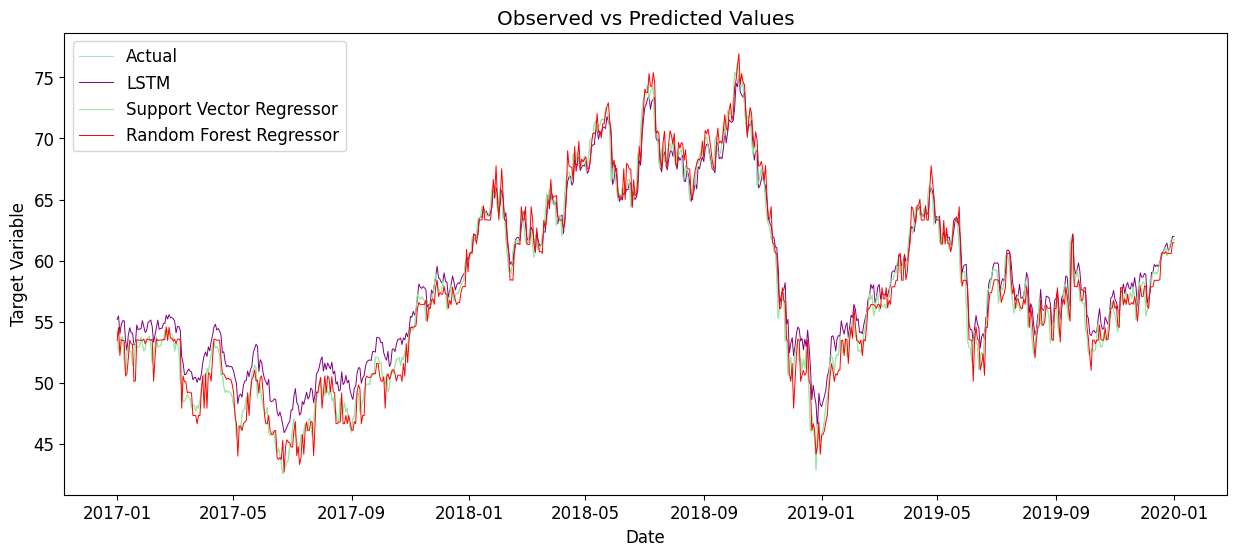

In [ ]:
plt.figure(figsize=(15, 6))

# Create date range
date_range = pd.date_range(start='01-01-2017', end='01-01-2020', periods=len(y_test_inverse))

plt.figure(figsize=(10, 6))
# Use date_range for x-axis
plt.plot(date_range, y_test_inverse, label='Actual', color='lightblue', linewidth=0.7)
plt.plot(date_range, y_pred_inverse_base_lstm, label='LSTM', color='purple', linewidth=0.7)
plt.plot(date_range, y_pred_base_svr, label='Support Vector Regressor', color='lightgreen', linewidth=0.7)
plt.plot(date_range, y_pred_base_rf, label='Random Forest Regressor', color='red', linewidth=0.7)

plt.title('Observed vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend(loc='upper left')

plt.show()


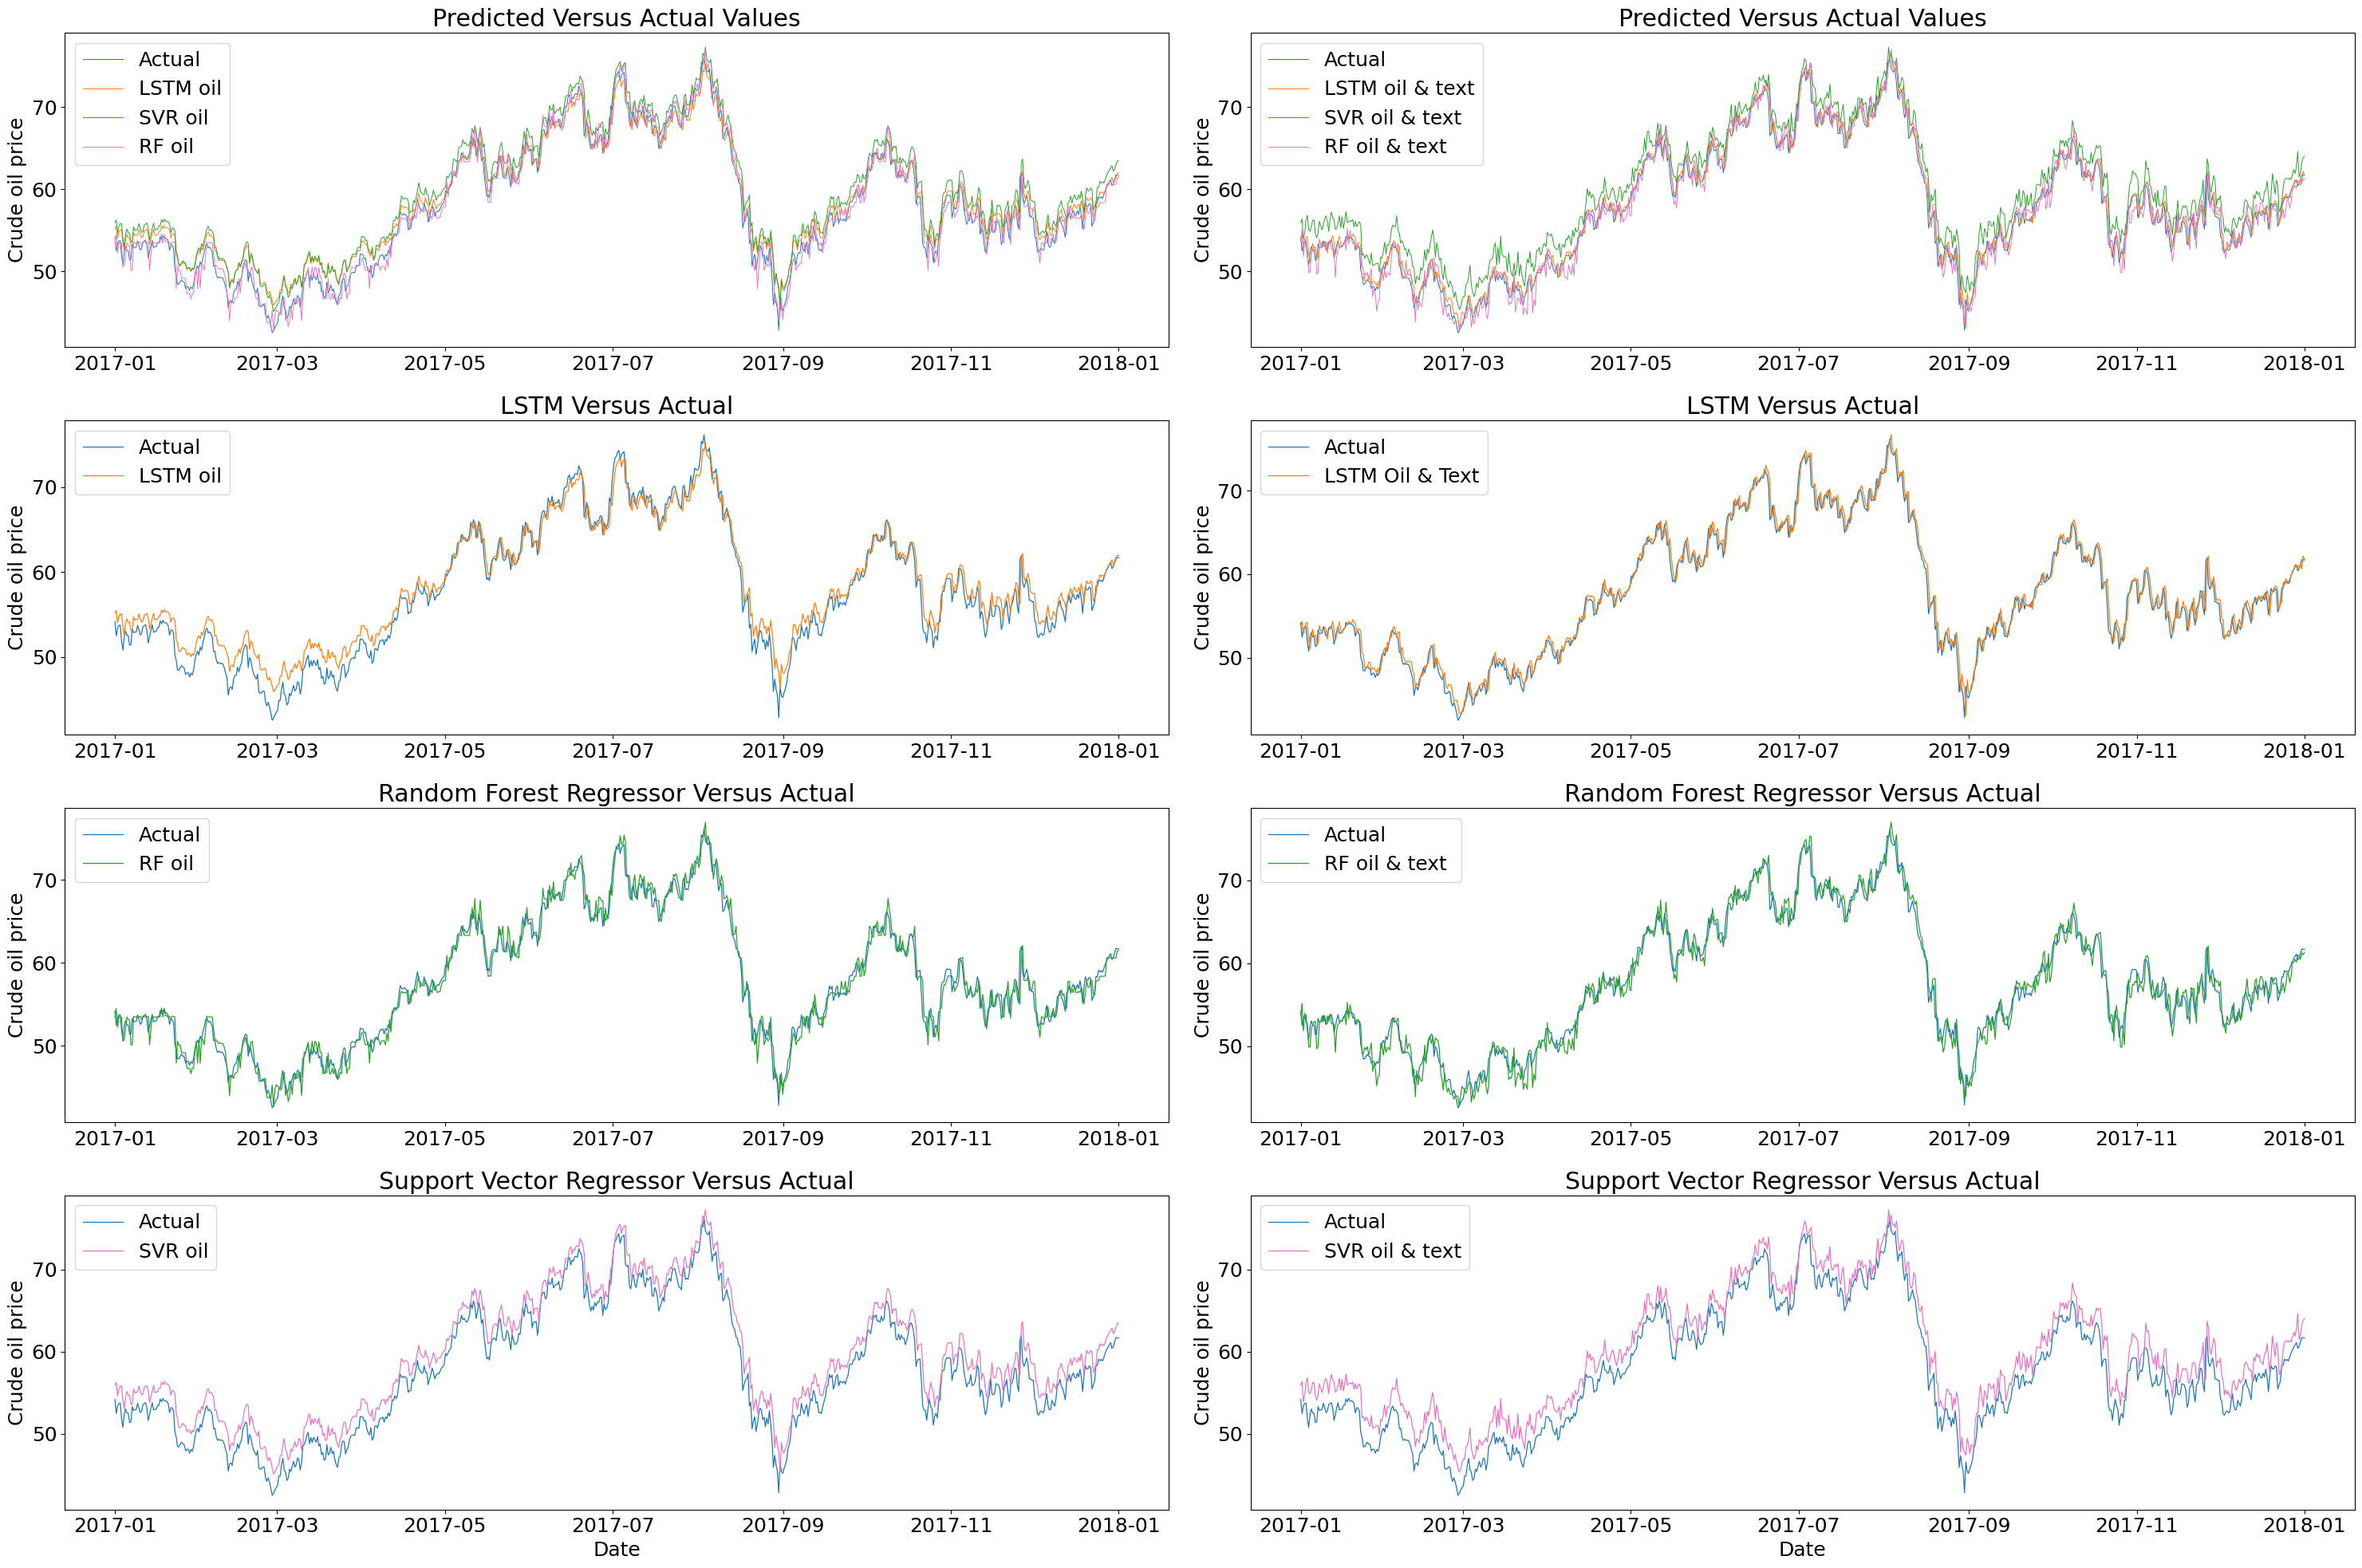

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(30, 20))  # Create 4 subplots, adjust the figure size accordingly

# Calculate the 20% mark for data
data_len = len(y_test_inverse)
twenty_percent_mark = int(data_len * 0.20)

# Create date range for 20% of the data
date_range = pd.date_range(start='01-01-2017', periods=twenty_percent_mark)

# Create date range
date_range = pd.date_range(start='01-01-2017', end='01-01-2018', periods=len(y_test_inverse))


# Main Plot
axs[0,0].plot(date_range, y_test_inverse[:twenty_percent_mark], label='Actual', color='C0', linewidth=0.7)
axs[0,0].plot(date_range, y_pred_inverse_base_lstm[:twenty_percent_mark], label='LSTM oil', color='C1', linewidth=0.7)
axs[0,0].plot(date_range, y_pred_base_svr[:twenty_percent_mark], label='SVR oil', color='C2', linewidth=0.7)
axs[0,0].plot(date_range, y_pred_base_rf[:twenty_percent_mark], label='RF oil', color='C6', linewidth=0.7)
axs[0,0].set_title('Predicted Versus Actual Values')
axs[0,0].set_ylabel('Crude oil price')
axs[0,0].legend(loc='upper left')

# LSTM vs Actual
axs[1,0].plot(date_range, y_test_inverse[:twenty_percent_mark], label='Actual', color='C0', linewidth=0.9)
axs[1,0].plot(date_range, y_pred_inverse_base_lstm[:twenty_percent_mark], label='LSTM oil', color='C1', linewidth=0.9)
axs[1,0].set_title('LSTM Versus Actual')
axs[1,0].set_ylabel('Crude oil price')
axs[1,0].legend(loc='upper left')

# RF vs Actual
axs[2,0].plot(date_range, y_test_inverse[:twenty_percent_mark], label='Actual', color='C0', linewidth=0.9)
axs[2,0].plot(date_range, y_pred_base_rf[:twenty_percent_mark], label='RF oil', color='C2', linewidth=0.9)
axs[2,0].set_title('Random Forest Regressor Versus Actual')
axs[2,0].set_ylabel('Crude oil price')
axs[2,0].legend(loc='upper left')

# SVR vs Actual
axs[3,0].plot(date_range, y_test_inverse[:twenty_percent_mark], label='Actual', color='C0', linewidth=0.9)
axs[3,0].plot(date_range, y_pred_base_svr[:twenty_percent_mark], label='SVR oil', color='C6', linewidth=0.9)
axs[3,0].set_title('Support Vector Regressor Versus Actual')
axs[3,0].set_xlabel('Date')  # Only the last plot gets the xlabel
axs[3,0].set_ylabel('Crude oil price')
axs[3,0].legend(loc='upper left')


# Main Plot
axs[0,1].plot(date_range, y_test_inverse, label='Actual', color='C0', linewidth=0.7)
axs[0,1].plot(date_range, y_pred_inverse_all_lstm, label='LSTM oil & text', color='C1', linewidth=0.7)
axs[0,1].plot(date_range, y_pred_all_svr, label='SVR oil & text', color='C2' ,linewidth=0.7)
axs[0,1].plot(date_range, y_pred_all_rf, label='RF oil & text', color='C6' ,linewidth=0.7)
axs[0,1].set_title('Predicted Versus Actual Values')
axs[0,1].set_ylabel('Crude oil price')
axs[0,1].legend(loc='upper left')

# LSTM vs Actual
axs[1,1].plot(date_range, y_test_inverse, label='Actual', color='C0', linewidth=0.9)
axs[1,1].plot(date_range, y_pred_inverse_all_lstm, label='LSTM Oil & Text', color='C1',linewidth=0.9)
axs[1,1].set_title('LSTM Versus Actual')
axs[1,1].set_ylabel('Crude oil price')
axs[1,1].legend(loc='upper left')

# RF vs Actual
axs[2,1].plot(date_range, y_test_inverse, label='Actual', color='C0', linewidth=0.9)
axs[2,1].plot(date_range, y_pred_all_rf, label='RF oil & text ', color='C2', linewidth=0.9)
axs[2,1].set_title('Random Forest Regressor Versus Actual')
axs[2,1].set_ylabel('Crude oil price')
axs[2,1].legend(loc='upper left')

# SVR vs Actual
axs[3,1].plot(date_range, y_test_inverse, label='Actual', color= 'C0', linewidth=0.9)
axs[3,1].plot(date_range, y_pred_all_svr, label='SVR oil & text', color='C6', linewidth=0.9)
axs[3,1].set_title('Support Vector Regressor Versus Actual')
axs[3,1].set_xlabel('Date')  # Only the last plot gets the xlabel
axs[3,1].set_ylabel('Crude oil price')
axs[3,1].legend(loc='upper left')

plt.tight_layout()  # To ensure sufficient spacing between plots

plt.savefig('/content/drive/MyDrive/Thesis Data Science Python/results_time_series.png')

plt.show()


# https://matplotlib.org/cheatsheets/cheatsheets.pdf

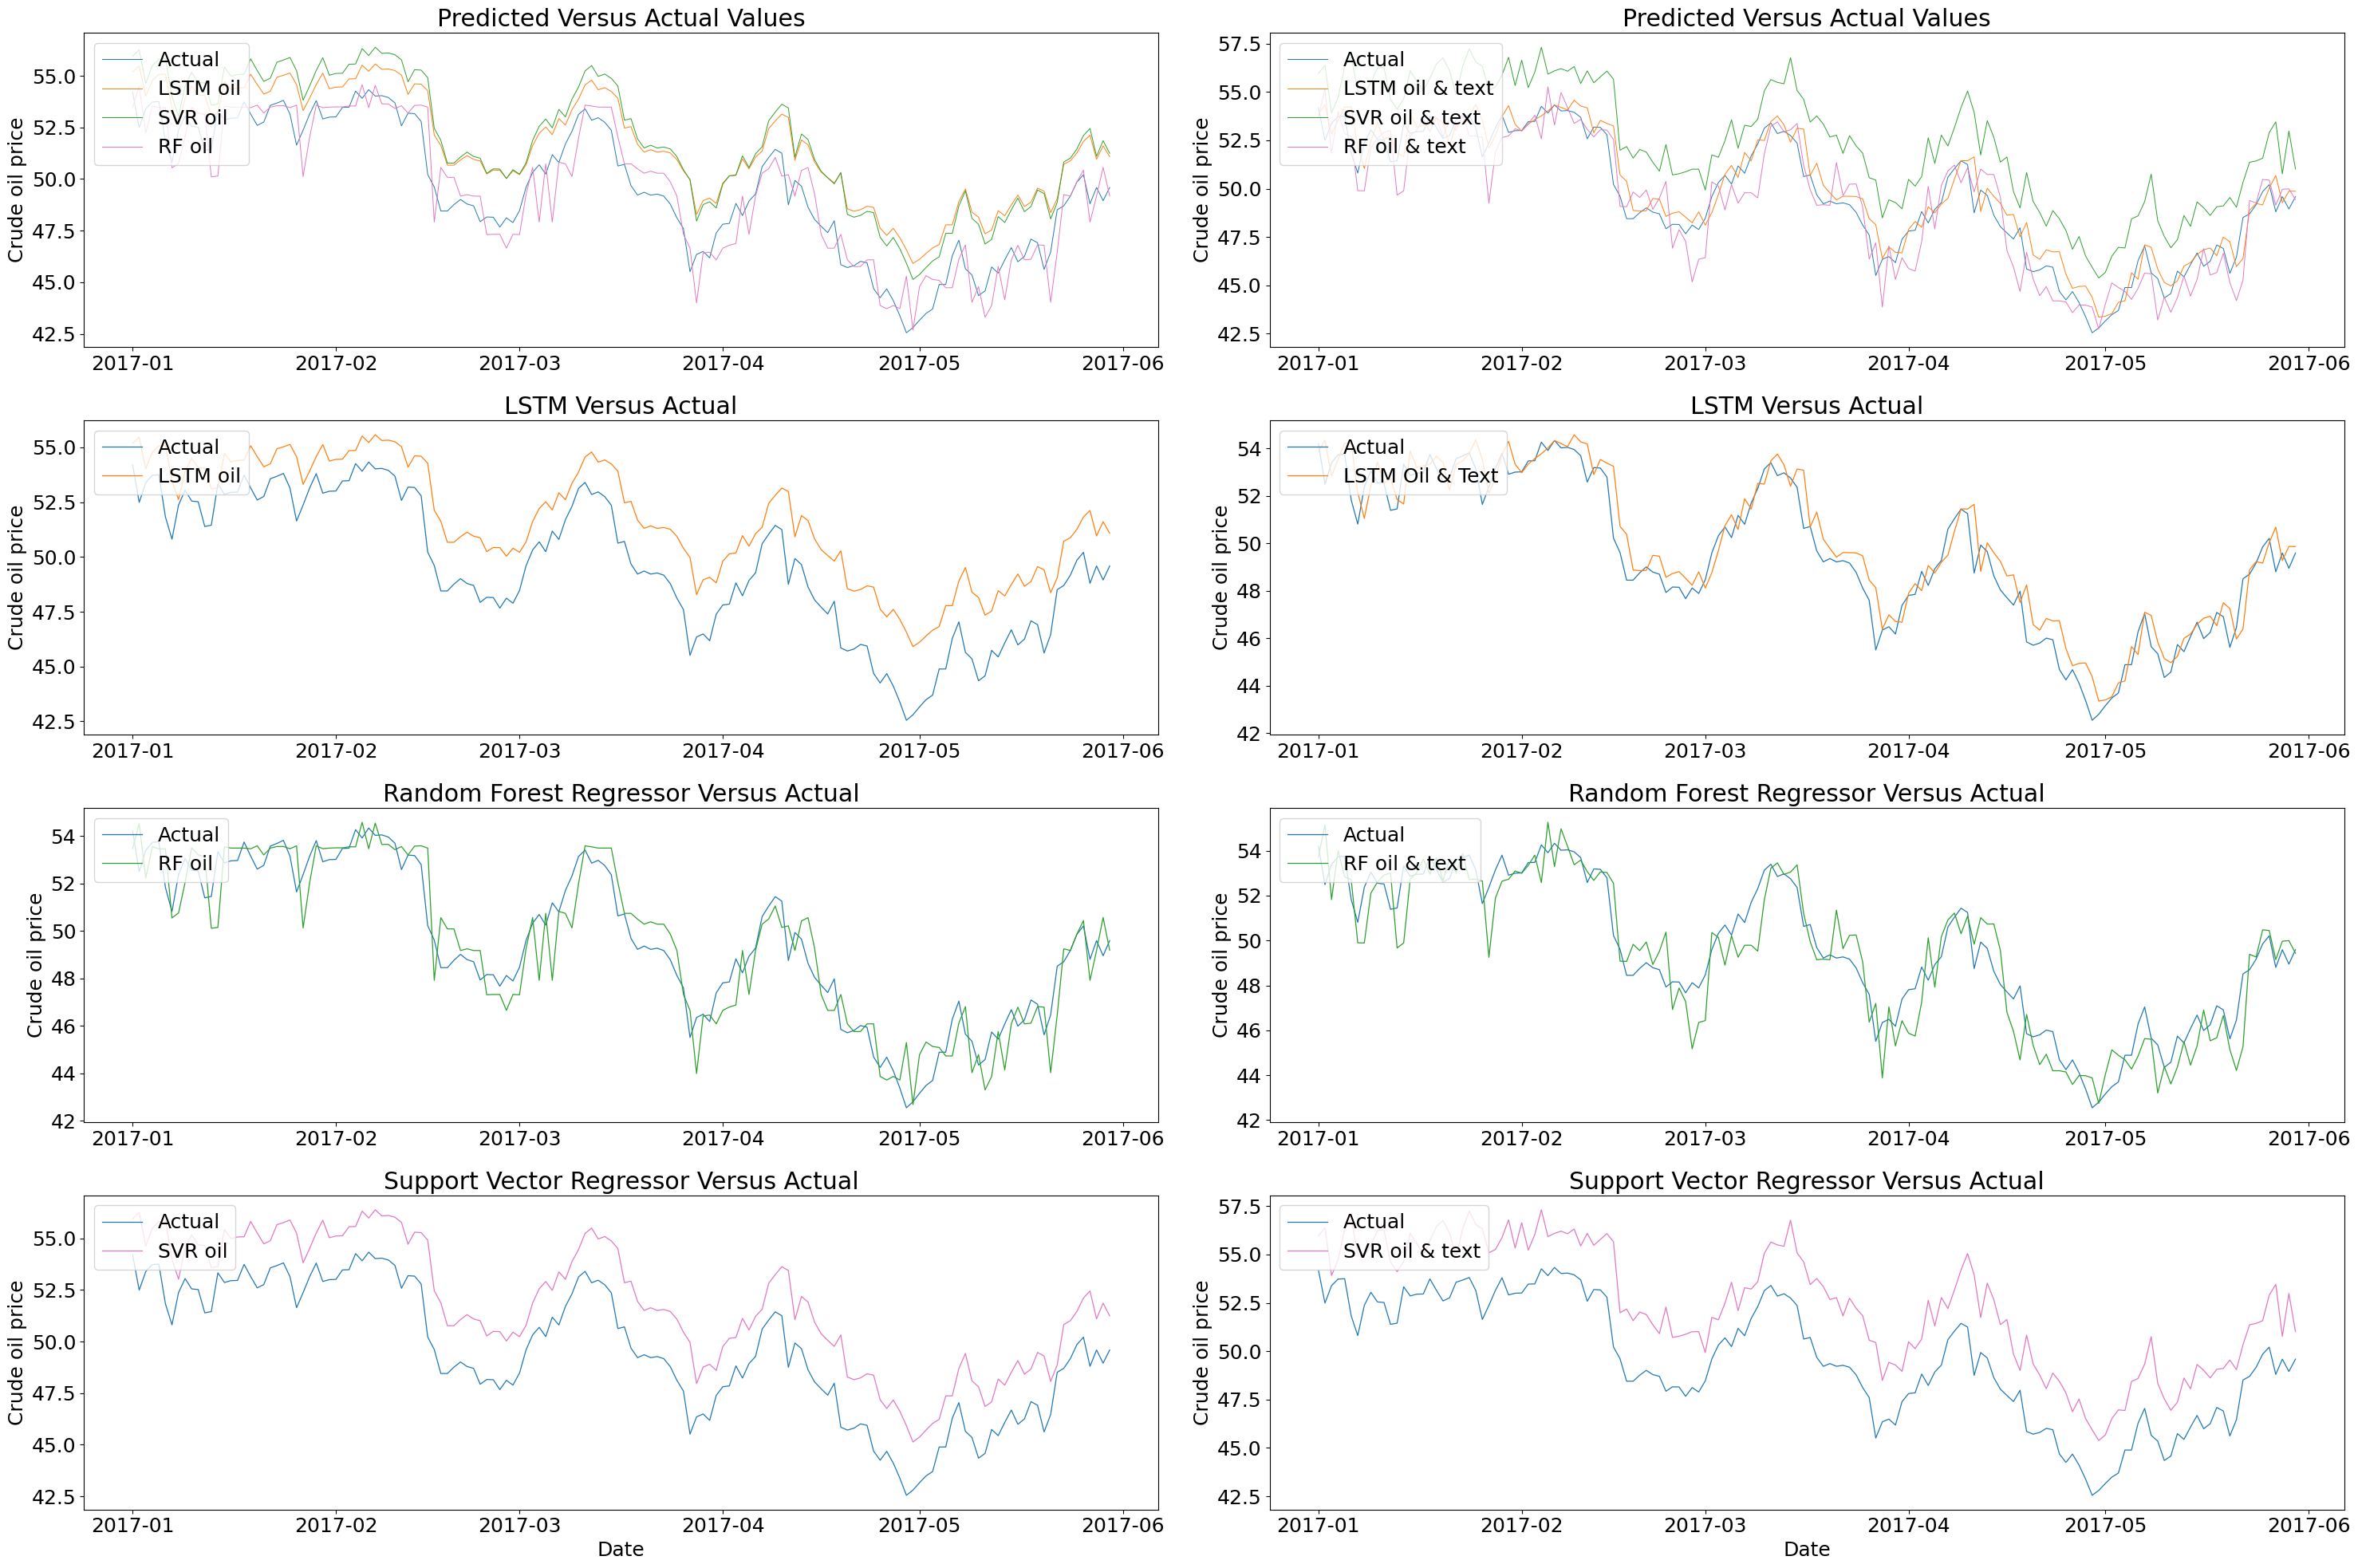

In [ ]:
# Calculate the 20% mark for your data
data_len = len(y_test_inverse)
twenty_percent_mark = int(data_len * 0.20)

# Create date range for 20% of the data
date_range = pd.date_range(start='01-01-2017', periods=twenty_percent_mark)

fig, axs = plt.subplots(4, 2, figsize=(30, 20))  # Create 4 subplots, adjust the figure size accordingly

# Main Plot
axs[0,0].plot(date_range, y_test_inverse[:twenty_percent_mark], label='Actual', color='C0', linewidth=0.7)
axs[0,0].plot(date_range, y_pred_inverse_base_lstm[:twenty_percent_mark], label='LSTM oil', color='C1', linewidth=0.7)
axs[0,0].plot(date_range, y_pred_base_svr[:twenty_percent_mark], label='SVR oil', color='C2', linewidth=0.7)
axs[0,0].plot(date_range, y_pred_base_rf[:twenty_percent_mark], label='RF oil', color='C6', linewidth=0.7)
axs[0,0].set_title('Predicted Versus Actual Values')
axs[0,0].set_ylabel('Crude oil price')
axs[0,0].legend(loc='upper left')

# LSTM vs Actual
axs[1,0].plot(date_range, y_test_inverse[:twenty_percent_mark], label='Actual', color='C0', linewidth=0.9)
axs[1,0].plot(date_range, y_pred_inverse_base_lstm[:twenty_percent_mark], label='LSTM oil', color='C1', linewidth=0.9)
axs[1,0].set_title('LSTM Versus Actual')
axs[1,0].set_ylabel('Crude oil price')
axs[1,0].legend(loc='upper left')

# RF vs Actual
axs[2,0].plot(date_range, y_test_inverse[:twenty_percent_mark], label='Actual', color='C0', linewidth=0.9)
axs[2,0].plot(date_range, y_pred_base_rf[:twenty_percent_mark], label='RF oil', color='C2', linewidth=0.9)
axs[2,0].set_title('Random Forest Regressor Versus Actual')
axs[2,0].set_ylabel('Crude oil price')
axs[2,0].legend(loc='upper left')

# SVR vs Actual
axs[3,0].plot(date_range, y_test_inverse[:twenty_percent_mark], label='Actual', color='C0', linewidth=0.9)
axs[3,0].plot(date_range, y_pred_base_svr[:twenty_percent_mark], label='SVR oil', color='C6', linewidth=0.9)
axs[3,0].set_title('Support Vector Regressor Versus Actual')
axs[3,0].set_xlabel('Date')  # Only the last plot gets the xlabel
axs[3,0].set_ylabel('Crude oil price')
axs[3,0].legend(loc='upper left')

# Main Plot
axs[0,1].plot(date_range, y_test_inverse[:twenty_percent_mark], label='Actual', color='C0', linewidth=0.7)
axs[0,1].plot(date_range, y_pred_inverse_all_lstm[:twenty_percent_mark], label='LSTM oil & text', color='C1', linewidth=0.7)
axs[0,1].plot(date_range, y_pred_all_svr[:twenty_percent_mark], label='SVR oil & text', color='C2', linewidth=0.7)
axs[0,1].plot(date_range, y_pred_all_rf[:twenty_percent_mark], label='RF oil & text', color='C6', linewidth=0.7)
axs[0,1].set_title('Predicted Versus Actual Values')
axs[0,1].set_ylabel('Crude oil price')
axs[0,1].legend(loc='upper left')

# LSTM vs Actual
axs[1,1].plot(date_range, y_test_inverse[:twenty_percent_mark], label='Actual', color='C0', linewidth=0.9)
axs[1,1].plot(date_range, y_pred_inverse_all_lstm[:twenty_percent_mark], label='LSTM Oil & Text', color='C1', linewidth=0.9)
axs[1,1].set_title('LSTM Versus Actual')
axs[1,1].set_ylabel('Crude oil price')
axs[1,1].legend(loc='upper left')

# RF vs Actual
axs[2,1].plot(date_range, y_test_inverse[:twenty_percent_mark], label='Actual', color='C0', linewidth=0.9)
axs[2,1].plot(date_range, y_pred_all_rf[:twenty_percent_mark], label='RF oil & text ', color='C2', linewidth=0.9)
axs[2,1].set_title('Random Forest Regressor Versus Actual')
axs[2,1].set_ylabel('Crude oil price')
axs[2,1].legend(loc='upper left')

# SVR vs Actual
axs[3,1].plot(date_range, y_test_inverse[:twenty_percent_mark], label='Actual', color='C0', linewidth=0.9)
axs[3,1].plot(date_range, y_pred_all_svr[:twenty_percent_mark], label='SVR oil & text', color='C6', linewidth=0.9)
axs[3,1].set_title('Support Vector Regressor Versus Actual')
axs[3,1].set_xlabel('Date')  # Only the last plot gets the xlabel
axs[3,1].set_ylabel('Crude oil price')
axs[3,1].legend(loc='upper left')

plt.tight_layout()  # To ensure sufficient spacing between plots
plt.savefig('/content/drive/MyDrive/Thesis Data Science Python/results_time_series.png')
plt.show()

plt.show()


# https://matplotlib.org/cheatsheets/cheatsheets.pdf

### Make stationary for ARIMA

In [ ]:
# Perform adf test to check stationarity
def adf_test(series):
    result = adfuller(series)
    return result[1]  # Return the p-value

# Make column stationary if it is not
def make_stationary(column, threshold=0.05):
    p_value = adf_test(column)
    diff_count = 0

    if p_value > threshold:
        while p_value > threshold:
            column = column.diff().dropna()
            p_value = adf_test(column)
            diff_count += 1

        return column, diff_count
    else:
        return column, diff_count

# Then use the old df to make the column stationary
for col in full_df.columns:
    stationary_col, diff_count = make_stationary(full_df[col])
    if diff_count > 0:
        # Create new column with '_diff' attached
        new_col_name = f"{col}_diff"

        # If the difference count is more than 1, add the count to the column name
        if diff_count > 1:
            new_col_name += f"_{diff_count}"

        full_df[new_col_name] = stationary_col

# Drop rows with NaN values that may have been created by differencing
full_df.dropna(inplace=True)


# https://medium.com/analytics-vidhya/brent-oil-prices-forecast-with-prophet-and-arima-50f5f177da5b


In [ ]:
arima_df = pd.DataFrame(full_df[['oil_price', 'oil_price_diff']])

# Normalize oil_price
def normalize_column(df, column_name):
    df_copy = df.copy() 
    scaler = MinMaxScaler()

    # Reshape the data for scaler
    data = df_copy[column_name].values.reshape(-1, 1)
    
  
    normalized_data = scaler.fit_transform(data)

    # Add normalized data as a new column
    df_copy[column_name + '_norm'] = normalized_data
    return df_copy, scaler

# Create a new df
arima_df, scaler = normalize_column(arima_df, 'oil_price')
arima_df, scaler = normalize_column(arima_df, 'oil_price_diff')

In [ ]:
# Split the datasets into training and validation sets while preserving the order
X_train_arima, X_test_arima   = arima_df[:test_split], arima_df[test_split:]
y_train, y_test  = arima_df[:test_split], arima_df[test_split:]

In [ ]:
# Turn df into series for arima forecasting
series = pd.Series(data = X_train_arima['oil_price_diff_norm'].to_numpy())

# Determine the order
best_aic = np.inf 
best_order = None
best_model = None

# Limit the maximum value of p and q
max_p = 5
max_q = 5
max_d = 3

# Find the best order
# Loop over p values
for p in range(max_p+1):
    # Loop over q values
    for q in range(max_q+1):
      for d in range(max_d +1): 
        try:
            temp_model = ARIMA(series, order=(p, d, q))
            temp_model_fit = temp_model.fit()
            temp_aic = temp_model_fit.aic
            if temp_aic < best_aic:
                best_aic = temp_aic
                best_order = (p, d, q)
                best_model = temp_model
        except:
            continue

print('Best ARIMA order:', best_order)
print('With min AIC:', best_aic)

Best ARIMA order: (1, 0, 0)
With min AIC: -4426.608950304028


In [ ]:
# Fit the MA model on the differenced and normalized target variable
model = ARIMA(series, order=(2,1,2))  # We're only considering a single lag for the moving average model
model_fit = model.fit()

# Make predictions on the differenced and normalized validation set
y_pred = model_fit.predict(start=len(X_train_arima), end=len(X_train_arima)+len(X_test_arima)-1)

y_test_inverse = scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_inverse = scaler.inverse_transform(y_pred.values.reshape(-1, 1))
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
rmse = sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))


print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


# https://www.kaggle.com/code/sajikim/ar-ma-arma-arima-prophet-lstm-regmodels/notebook?scriptVersionId=37840360

MAE: 12.548749345891649
RMSE: 14.385061854698106


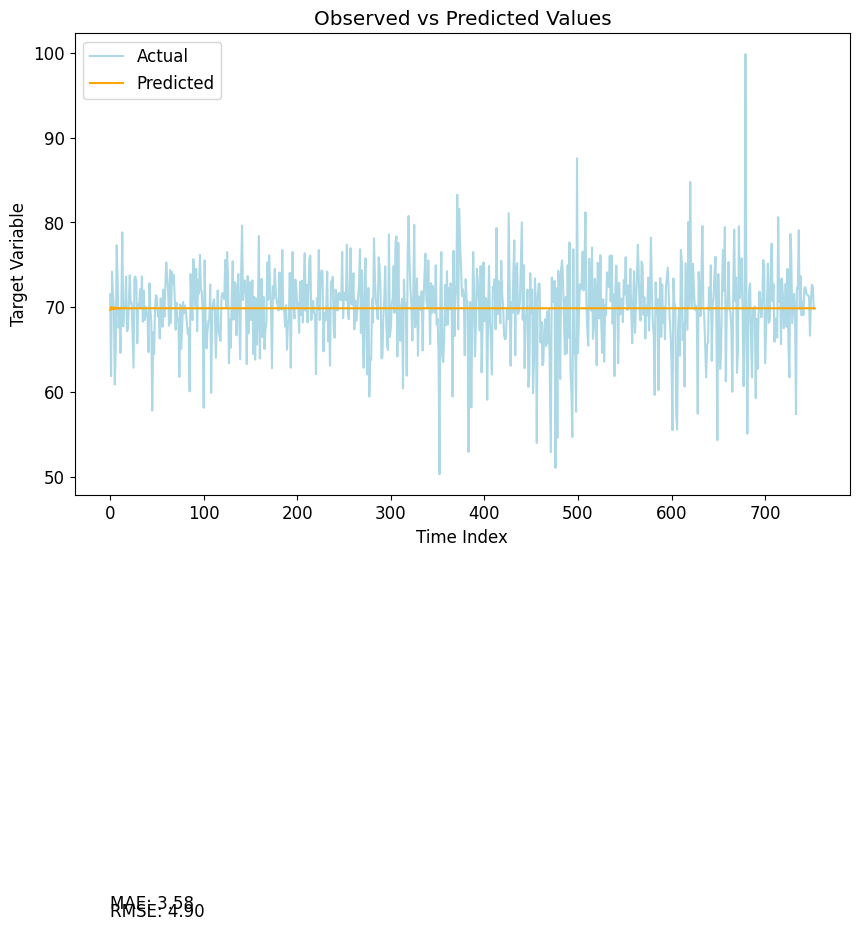

In [ ]:
# Plotting the observed vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='Actual', color='lightblue')
plt.plot(y_pred_inverse, label='Predicted', color='orange')

plt.title('Observed vs Predicted Values')
plt.xlabel('Time Index')
plt.ylabel('Target Variable')
plt.legend(loc='upper left')

# Print the MAE and RMSE values on the plot
plt.text(x=0, y=-1, s=f"MAE: {mae:.2f}", fontsize=12)
plt.text(x=0, y=-2, s=f"RMSE: {rmse:.2f}", fontsize=12)

plt.show()


# Error analysis

In [ ]:
# Extract datetime index from the test data
test_dates = X_test_base.index


# Extract datetime index from the test data
test_dates = X_test_base.index


# Use the validation function to get the results for the models
def validate_model(X_train, y_train, X_test, y_test, best_params, dates):
    model = RandomForestRegressor(**best_params)
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    # Inverse transform the y_val and y_pred
    y_test_inverse = scaler.inverse_transform(y_test.values.reshape(-1, 1))
    y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    rmse = sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
    # Create a dataframe to store the dates, actuals, predictions and errors
    results = pd.DataFrame({
        'date': dates,
        'actual': y_test_inverse.flatten(),
        'prediction': y_pred_inverse.flatten(),
        'abs_error': np.abs(y_test_inverse.flatten() - y_pred_inverse.flatten()),
        'squared_error': (y_test_inverse.flatten() - y_pred_inverse.flatten()) ** 2
    })
    return mae, rmse, results


mae_base, rmse_base, results_base = validate_model(X_train_base, y_train, X_test_base, y_test, best_params_base, test_dates)
mae_all, rmse_all, results_all = validate_model(X_train_all, y_train, X_test_all, y_test, best_params_all, test_dates)

# Define the seasons
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

# the results based on the seasons
results_base['season'] = results_base['date'].apply(get_season)
results_all['season'] = results_all['date'].apply(get_season)

# Group the results based on the seasons
results_base.groupby('season').agg({'abs_error': 'mean', 'squared_error': 'mean'}).apply(np.sqrt)
results_all.groupby('season').agg({'abs_error': 'mean', 'squared_error': 'mean'}).apply(np.sqrt)




,abs_error,squared_error
season,,
Fall,0.978719,1.307432
Spring,0.903663,1.055189
Summer,0.989582,1.269740
Winter,0.922919,1.090424


In [ ]:

# Extract datetime index from the test data
test_dates = X_test_base.index

# Define the validate_model function
def validate_model(X_train, y_train, X_test, y_test, best_params, dates):
    model = SVR(**best_params)
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    y_test_inverse = scaler.inverse_transform(y_test.values.reshape(-1, 1))
    y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    rmse = sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
    # Create a dataframe to store the dates, actuals, predictions and errors
    results = pd.DataFrame({
        'date': dates,
        'actual': y_test_inverse.flatten(),
        'prediction': y_pred_inverse.flatten(),
        'abs_error': np.abs(y_test_inverse.flatten() - y_pred_inverse.flatten()),
        'squared_error': (y_test_inverse.flatten() - y_pred_inverse.flatten()) ** 2
    })
    return mae, rmse, results

# Define best parameters for all features and base features for SVR
best_params_all_svr = results_svr_tuning.loc[results_svr_tuning['Feature Set'] == 'All Features', 'Best Hyperparameters'].values[0]
best_params_base_svr = results_svr_tuning.loc[results_svr_tuning['Feature Set'] == 'Base Features', 'Best Hyperparameters'].values[0]

mae_base, rmse_base, results_base = validate_model(X_train_base, y_train, X_test_base, y_test, best_params_base_svr, test_dates)
mae_all, rmse_all, results_all = validate_model(X_train_all, y_train, X_test_all, y_test, best_params_all_svr, test_dates)


def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

results_base['season'] = results_base['date'].apply(get_season)
results_all['season'] = results_all['date'].apply(get_season)


svr_error_base = results_base.groupby('season').agg({'abs_error': 'mean', 'squared_error': 'mean'}).apply(np.sqrt)
svr_error_all = results_all.groupby('season').agg({'abs_error': 'mean', 'squared_error': 'mean'}).apply(np.sqrt)

In [ ]:
svr_error_base

,abs_error,squared_error
season,,
Fall,1.406763,2.227951
Spring,1.362486,2.088349
Summer,1.410408,2.253074
Winter,1.382342,2.136156
